# Supervised ML Project

## 1. Library loading

In [6]:
import pandas as pd
import numpy as np

# MICE imputation----------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from sklearn.ensemble import RandomForestRegressor 

# Skewed variable transformation-------------------------------------
from scipy.stats import skew

# Data visualization-------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# XGBoost------------------------------------------------------------
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import ElasticNet, ElasticNetCV # To prevent overfitting
from sklearn.feature_selection import SelectFromModel

import time
import joblib
import warnings
warnings.filterwarnings("ignore")

## 2. Data loading

In [7]:
df_train = pd.read_csv("./CSV/train.csv")
df_test  = pd.read_csv("./CSV/test.csv")
print('Train shape:', df_train.shape)
print('Test shape :', df_test.shape)
print('SalePrice appears in train and not in test, that explain the column number difference.')

Train shape: (1460, 81)
Test shape : (1459, 80)
SalePrice appears in train and not in test, that explain the column number difference.


## 3. Outliers

### 3.1. Selection of continuous features

- Excluded:
  - `SalePrice`: is the target variable.
  - `MSSubClass`, `OverallQual`, `OverallCond`, `MoSold`, `YrSold`: whilst being numerical, these variables do not reflect continuous magnitudes.

In [8]:
cols_to_exclude = ['Id', 'MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']
numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
continuous_cols = [col for col in numeric_cols if col not in cols_to_exclude and col != 'SalePrice']

### 3.2. Capping outliers in numeric features

In [9]:
def apply_iqr_capping(df_train, df_test, columns, fold=1.5):
    for col in columns:
        # Calculation of Q1, Q3 and IQR only to df_train)
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Threshold definition
        lower_limit = Q1 - fold * IQR
        upper_limit = Q3 + fold * IQR
        
        # Capping application to df_train
        df_train[col] = np.where(df_train[col] > upper_limit, upper_limit, df_train[col])
        df_train[col] = np.where(df_train[col] < lower_limit, lower_limit, df_train[col])
        
        # Capping application to df_test
        df_test[col] = np.where(df_test[col] > upper_limit, upper_limit, df_test[col])
        df_test[col] = np.where(df_test[col] < lower_limit, lower_limit, df_test[col])
        
    print(f"Capping (1.5 * IQR) applied to {len(columns)} numerical variables in TRAIN and TEST.")
    return df_train, df_test

# Function application
df_train, df_test = apply_iqr_capping(df_train, df_test, continuous_cols)
print('Beware of data compression for repeated cell runs without restoring the original data.')

Capping (1.5 * IQR) applied to 31 numerical variables in TRAIN and TEST.
Beware of data compression for repeated cell runs without restoring the original data.


### 3.3. Automatic skew correction for features using the 0.75 skewness threshold

In [10]:
# Skewness calculation for all numerical columns
skewness = df_train[continuous_cols].apply(lambda x: skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > 0.75].index 

# Application of log1p function
for col in skewed_cols:
    df_train[col] = np.log1p(df_train[col])
    if col in df_test.columns:
        df_test[col] = np.log1p(df_test[col])
print(list(skewed_cols))

['MasVnrArea', 'BsmtUnfSF', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF']


### 3.4. Engineering of new features based on insights and removal of repeated information

In [11]:
# Creation of new variables
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

df_train['HouseAge'] = df_train['YrSold'] - df_train['YearBuilt']
df_test['HouseAge'] = df_test['YrSold'] - df_test['YearBuilt']

df_train['Remodeled'] = (df_train['YearBuilt'] != df_train['YearRemodAdd']).astype(int)
df_test['Remodeled'] = (df_test['YearBuilt'] != df_test['YearRemodAdd']).astype(int)

# Removal of repeated information
cols_to_drop = [
    'YearBuilt', 'YrSold', 'YearRemodAdd', 
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']

df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

## 4. Missing Data

### 4. 1. Preliminary summary

In [12]:
# Missing values counting
nan_count = df_train.isnull().sum()
    
# Percentage calculation
nan_percentage = 100 * nan_count / len(df_train)

# Crear un a tabla con count y percentage
nan_table = pd.DataFrame({'Valores Faltantes': nan_count, 'Porcentaje Faltante': nan_percentage})
nan_table = nan_table[nan_table['Valores Faltantes'] != 0].sort_values('Porcentaje Faltante', ascending=False).round(1)
display(nan_table)

,Valores Faltantes,Porcentaje Faltante
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
MasVnrType,872,59.7
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5


### 4. 2. Removal of features with over 15% missing values

In [13]:
nan_percentage_train = 100 * df_train.isnull().sum() / len(df_train)

# List of columns with over 15% missing values
UMBRAL = 15.0 
columnas_a_eliminar = nan_percentage_train[nan_percentage_train > UMBRAL].index.tolist()

# Dropping columns in df_train
df_train_cleaned = df_train.drop(columns=columnas_a_eliminar)

# Eliminar las columnas correspondientes de df_test
# 'errors="ignore"' because SalePrice does not appear in df_test
df_test_cleaned = df_test.drop(columns=columnas_a_eliminar, errors='ignore')

### 4. 3. MICE imputation

#### 4. 3. 1. One-Hot-Encoding (OHE)

In [15]:
# Select target variable (y_train), features for training (X_train), and create a copy of the test set (X_test)
y_train = df_train_cleaned['SalePrice']
X_train = df_train_cleaned.drop('SalePrice', axis=1)
X_test = df_test_cleaned.copy() 

# Concatenation to assure OHE has the same columns 
df_combined = pd.concat([X_train, X_test], ignore_index=True)

# OHE application
df_combined_encoded = pd.get_dummies(df_combined, dtype=int)

# Separation
X_train_encoded = df_combined_encoded.iloc[:len(X_train)]
X_test_encoded = df_combined_encoded.iloc[len(X_train):]
print(X_train_encoded.shape, X_test_encoded.shape)

(1460, 263) (1459, 263)


#### 4. 3. 2. Removal of zero-variance features

In [165]:
# Identification of features with standard deviation equal to zero
cols_to_drop = [col for col in X_train_encoded.columns if X_train_encoded[col].std() == 0]

# Features
if cols_to_drop:
    print("Variables eliminadas por tener Varianza Cero (Std = 0):")
    print(cols_to_drop)
else:
    print("No se eliminó ninguna variable por tener Varianza Cero.")

# Removal of features
X_train_encoded.drop(columns=cols_to_drop, inplace=True)
X_test_encoded.drop(columns=cols_to_drop, inplace=True)

Variables eliminadas por tener Varianza Cero (Std = 0):
['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


 #### 4. 3. 3. Standardization

In [166]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded) 
X_test_scaled = scaler.transform(X_test_encoded)      

# Conversion to DataFrame 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

#### 4. 3. 4. MICE application

In [167]:
mice_imputer = IterativeImputer(
    max_iter=10, 
    random_state=42, 
    estimator=RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42), # Use of RF to also capturing non-linears
    verbose=2 
)

# Fit and impute using ONLY the training set
X_train_imputed_scaled = mice_imputer.fit_transform(X_train_scaled)
X_train_imputed = pd.DataFrame(X_train_imputed_scaled, columns=X_train_scaled.columns)
X_train_imputed['SalePrice'] = y_train.values # Reintegrar SalePrice

# Impute the TEST set using the fitted model
X_test_imputed_scaled = mice_imputer.transform(X_test_scaled)
X_test_imputed = pd.DataFrame(X_test_imputed_scaled, columns=X_test_scaled.columns)

[IterativeImputer] Completing matrix with shape (1460, 254)
[IterativeImputer] Ending imputation round 1/10, elapsed time 32.16
[IterativeImputer] Change: 2.228436100846254, scaled tolerance: 0.03819685850956858 
[IterativeImputer] Ending imputation round 2/10, elapsed time 64.63
[IterativeImputer] Change: 5.551115123125783e-17, scaled tolerance: 0.03819685850956858 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1459, 254)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.03
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.05


## 5. Exploration of `SalePrice` distribution

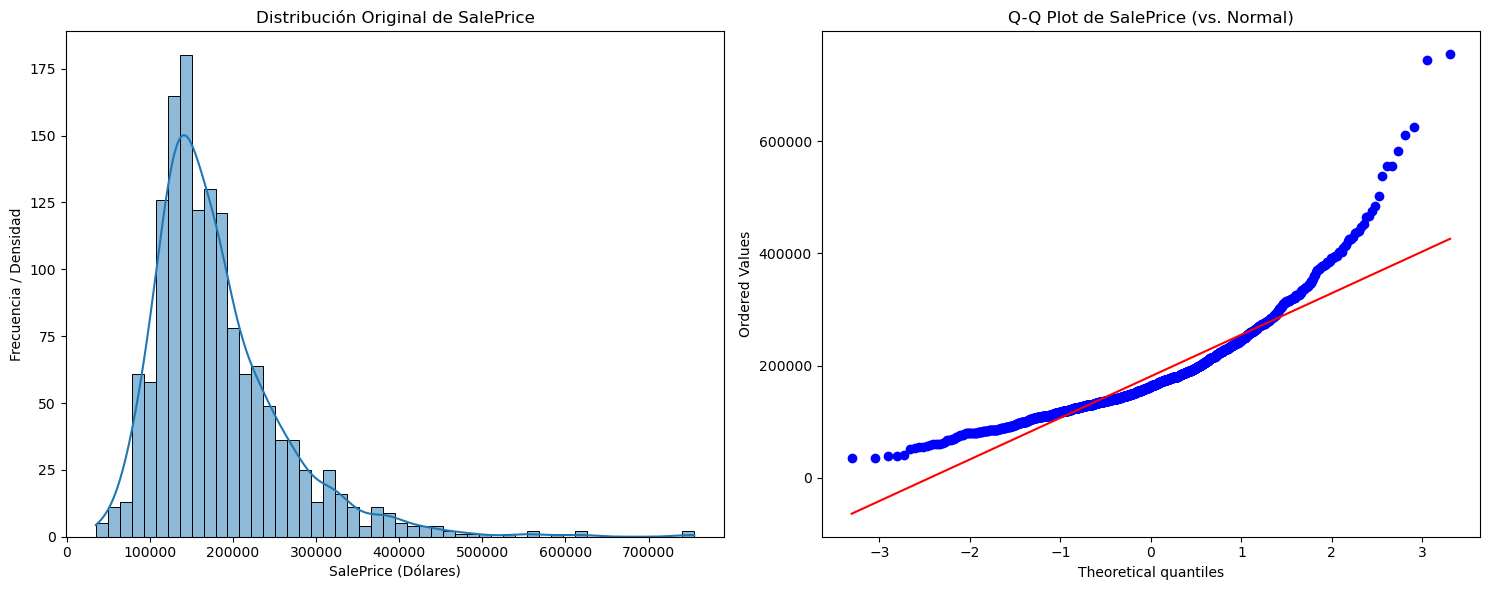

In [168]:
# Figure configuration
plt.figure(figsize=(15, 6))

# --- Subplot 1: Histogram and Density Curve (KDE) ---
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribución Original de SalePrice')
plt.xlabel('SalePrice (Dólares)')
plt.ylabel('Frecuencia / Densidad')

# --- Subplot 2: Q-Q Plot (Quantile-Quantile Plot) ---
# Compares the distribution of SalePrice with a theoretical normal distribution
plt.subplot(1, 2, 2)
stats.probplot(y_train, dist="norm", plot=plt)
plt.title('Q-Q Plot de SalePrice (vs. Normal)')

plt.tight_layout()
plt.show()

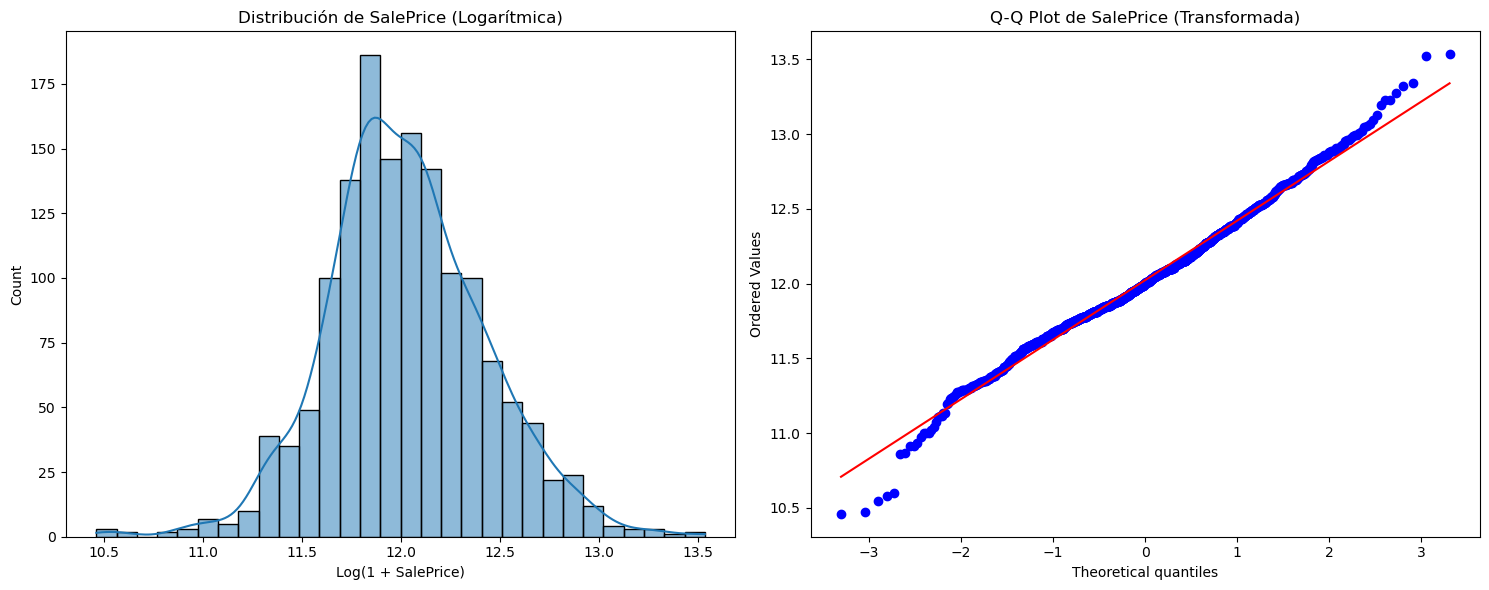

In [169]:
# Transformation applciation
y_train_log = np.log1p(y_train)

# Visualization
plt.figure(figsize=(15, 6))

# Histogram of transformed SalePrice
plt.subplot(1, 2, 1)
sns.histplot(y_train_log, kde=True, bins=30)
plt.title('Distribución de SalePrice (Logarítmica)')
plt.xlabel('Log(1 + SalePrice)')

# Q-Q Plot of transformed SalePrice
plt.subplot(1, 2, 2)
stats.probplot(y_train_log, dist="norm", plot=plt)
plt.title('Q-Q Plot de SalePrice (Transformada)')

plt.tight_layout()
plt.show()

## 6. Model Fitting

### 6. 1. Data Preparation

In [170]:
X = X_train_imputed.drop(columns=['SalePrice']).copy()
y = y_train_log.copy() 
X_test_final = X_test_imputed.copy()
print("Shapes:", X.shape, y.shape, X_test_final.shape)

Shapes: (1460, 254) (1460,) (1459, 254)


### 6. 2. RMSE CV function

In [171]:
def cv_rmse(model, X, y, folds=5, random_state=42):
    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    # Negative MSE scoring for cross_val_score compatibility
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1)
    rmses = np.sqrt(-scores)
    return rmses.mean(), rmses.std()

### 6. 3. Baseline: XGBoost with default parameters

In [172]:
xgb_baseline = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='auto',
    n_jobs=-1,
    verbosity=0
)

t0 = time.time()
mean_rmse_xgb, std_rmse_xgb = cv_rmse(xgb_baseline, X, y, folds=5)
t1 = time.time()
print(f"[XGB baseline] RMSE log-scale: {mean_rmse_xgb:.5f} ± {std_rmse_xgb:.5f}  (t={t1-t0:.1f}s)")

[XGB baseline] RMSE log-scale: 0.12807 ± 0.02141  (t=3.8s)


### 6. 4. Baseline: ElasticNet (regulalized)

In [173]:
elastic = ElasticNet(random_state=42, max_iter=5000)

t0 = time.time()
mean_rmse_enet, std_rmse_enet = cv_rmse(elastic, X, y, folds=5)
t1 = time.time()
print(f"[ElasticNet baseline] RMSE log-scale: {mean_rmse_enet:.5f} ± {std_rmse_enet:.5f}  (t={t1-t0:.1f}s)")

[ElasticNet baseline] RMSE log-scale: 0.39878 ± 0.02513  (t=1.5s)


### 6. 5. Hyperparameter search (RandomizedSearch) for XGBoost

In [174]:
xgb_param_dist = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.5, 1, 2, 5]
}

rs_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

t0 = time.time()
rs_xgb.fit(X, y)
t1 = time.time()
print(f"Best score (neg MSE): {rs_xgb.best_score_:.5f}")
print("Best params XGB:", rs_xgb.best_params_)
best_xgb = rs_xgb.best_estimator_

# Final CV evaluation of best estimator (4 folds)
mean_rmse_xgb_tuned, std_rmse_xgb_tuned = cv_rmse(best_xgb, X, y, folds=5)
print(f"[XGB tuned] RMSE log-scale: {mean_rmse_xgb_tuned:.5f} ± {std_rmse_xgb_tuned:.5f}")

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best score (neg MSE): -0.01452
Best params XGB: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.5}
[XGB tuned] RMSE log-scale: 0.12516 ± 0.02100


### 6. 6. Hyperparameter search for ElasticNet

In [175]:
enet_cv = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .9], 
                       alphas=np.logspace(-4, 0, 30),
                       cv=5, n_jobs=-1, random_state=42, max_iter=5000)
enet_cv.fit(X, y)
print("ElasticNetCV: mejor alpha:", enet_cv.alpha_, " mejor l1_ratio:", enet_cv.l1_ratio_)

# CV score with best hyperparameters
enet_best = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=5000, random_state=42)
mean_rmse_enet_tuned, std_rmse_enet_tuned = cv_rmse(enet_best, X, y, folds=5)
print(f"[ElasticNet tuned] RMSE log-scale: {mean_rmse_enet_tuned:.5f} ± {std_rmse_enet_tuned:.5f}")

ElasticNetCV: mejor alpha: 0.011721022975334805  mejor l1_ratio: 0.3
[ElasticNet tuned] RMSE log-scale: 0.12418 ± 0.01512


### 6. 7. Learning Curve (XGB) - overfitting inspection

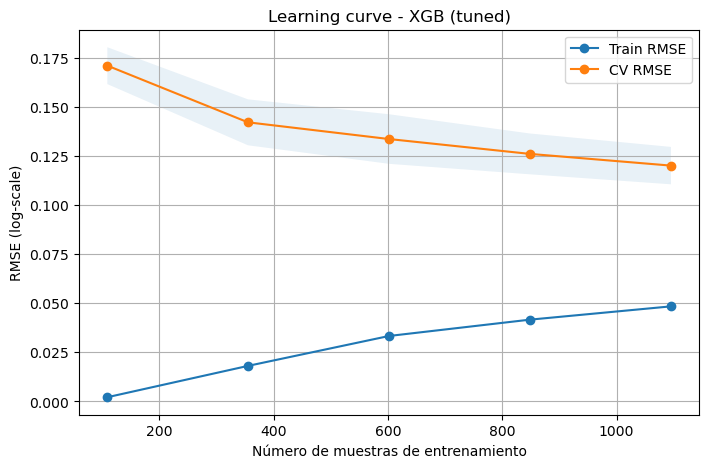

In [176]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            scoring=scoring, n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 5), random_state=42)
    train_rmse = np.sqrt(-train_scores)
    test_rmse = np.sqrt(-test_scores)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', label="Train RMSE")
    plt.plot(train_sizes, test_rmse.mean(axis=1), 'o-', label="CV RMSE")
    plt.fill_between(train_sizes, test_rmse.mean(axis=1)-test_rmse.std(axis=1),
                     test_rmse.mean(axis=1)+test_rmse.std(axis=1), alpha=0.1)
    plt.xlabel("Número de muestras de entrenamiento")
    plt.ylabel("RMSE (log-scale)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(best_xgb, X, y, title="Learning curve - XGB (tuned)", cv=KFold(n_splits=4, shuffle=True, random_state=42))

### 6. 8. Feature Importance


Top 30 Important features (XGB):
ExterQual_TA           0.137625
OverallQual            0.102492
BsmtQual_Ex            0.060542
GarageCars             0.052744
GrLivArea              0.034796
KitchenQual_TA         0.030086
HouseAge               0.028329
CentralAir_Y           0.026270
Fireplaces             0.021063
CentralAir_N           0.019435
GarageType_Attchd      0.019424
FullBath               0.018573
TotalSF                0.018125
PavedDrive_N           0.015422
BsmtQual_TA            0.014641
GarageType_Detchd      0.012578
GarageQual_TA          0.012224
BsmtFinType1_Unf       0.010072
GarageCond_TA          0.009504
BldgType_1Fam          0.009144
LotShape_Reg           0.008951
BsmtFinType1_GLQ       0.008933
MSZoning_RL            0.008678
HalfBath               0.008608
KitchenQual_Ex         0.008420
MSZoning_RM            0.008125
Neighborhood_IDOTRR    0.007966
BsmtFinSF1             0.007700
KitchenQual_Gd         0.007287
MSZoning_C (all)       0.006996
dtype:

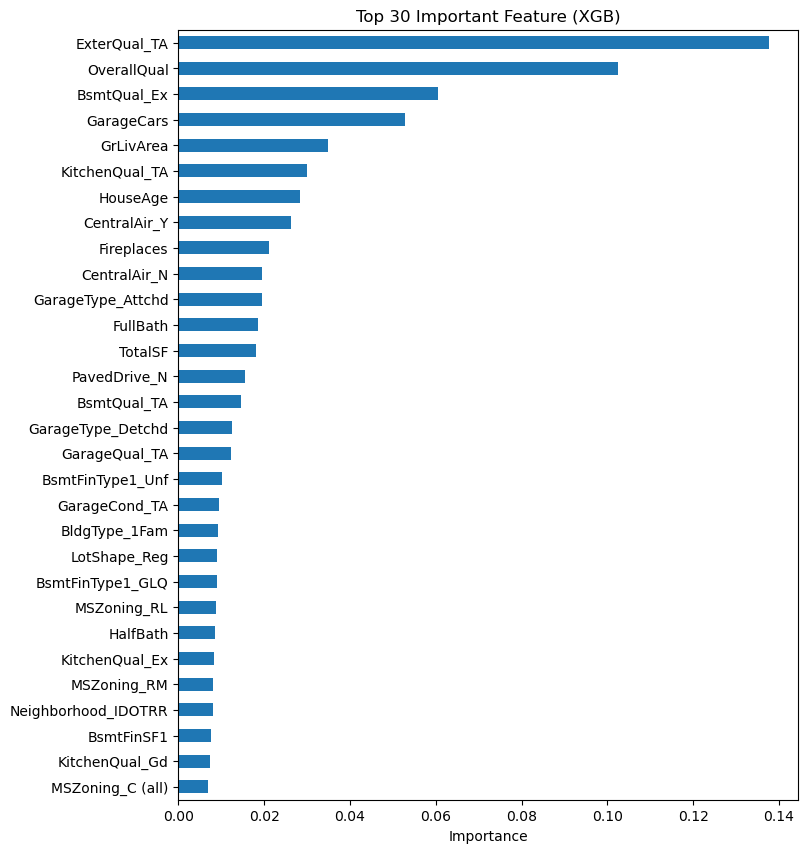

In [177]:
fi = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 30 Important features (XGB):")
print(fi.head(30))

plt.figure(figsize=(8,10))
fi.head(30).sort_values().plot(kind='barh')
plt.title("Top 30 Important Feature (XGB)")
plt.xlabel("Importance")
plt.show()

### 6. 9. Feature selection over importance

In [178]:
sfm = SelectFromModel(best_xgb, threshold="median", prefit=True) 
X_reduced = sfm.transform(X)
X_test_reduced = sfm.transform(X_test_final)

print("Original Shape X:", X.shape)
print("Reduced Shape X :", X_reduced.shape)

# Re-evaluation of XGB over reduced set
mean_rmse_xgb_reduced, std_rmse_xgb_reduced = cv_rmse(best_xgb, X_reduced, y, folds=5)
print(f"[XGB reduced] RMSE log-scale: {mean_rmse_xgb_reduced:.5f} ± {std_rmse_xgb_reduced:.5f}")

Original Shape X: (1460, 254)
Reduced Shape X : (1460, 127)
[XGB reduced] RMSE log-scale: 0.12480 ± 0.02166


### 6. 10. Final fitting and prediction (ensambled: avg XGB + ElasticNet)

In [179]:
# Entrenamos los modelos finales sobre el conjunto de entrenamiento REDUCIDO
best_xgb.fit(X_reduced, y) 
enet_best.fit(X_reduced, y)

# Predicciones log-scale en test (usando el conjunto de prueba reducido)
pred_xgb_log = best_xgb.predict(X_test_reduced) 
pred_enet_log = enet_best.predict(X_test_reduced) 

# Combinación
pred_ensemble_log = (pred_xgb_log)*0.55 + (pred_enet_log)*0.45

### 6. 11. Restoration of log1p

In [180]:
pred_ensemble = np.expm1(pred_ensemble_log)
pred_xgb = np.expm1(pred_xgb_log)
pred_enet = np.expm1(pred_enet_log)

## 7. Submission

In [181]:
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': pred_ensemble
})
submission.to_csv('submission.csv', index=False)